![image1](https://s3-us-west-2.amazonaws.com/prd-rteditorial/wp-content/uploads/2018/03/13153742/RT_300EssentialMovies_700X250.jpg)

# Predicting Movie Revenues: An Analytical Approach

## Introduction

In the competitive world of film production, predicting a movie’s revenue before its release is a challenge yet a necessity. It allows stakeholders to make informed decisions regarding marketing strategies, distribution plans, and other critical aspects. This project embarks on an in-depth analysis of various features that might impact a movie's revenue, with the ultimate goal of developing a robust predictive model. This model aims to estimate the revenue of movies based on features such as budget, genre, production companies, and countries, release dates, and runtime.

## Business Context

**Background:**
The global film industry is a multi-billion-dollar industry with substantial economic impact and influence. Understanding the potential revenue a movie can generate is crucial for production companies, investors, and other stakeholders involved in the movie-making process.

**Problem Statement:**
Building an accurate and reliable model to predict a movie's revenue can significantly enhance decision-making, budget allocation, and risk assessment. This project aims to fill this gap by utilizing a diverse dataset encompassing various aspects of movies and employing advanced machine learning techniques.

**Objective:**
The primary objective is to explore, analyze, and model the dataset to predict the revenue of movies. The model's performance is continuously assessed and refined to ensure its reliability and accuracy.

## Data Overview

The dataset used in this project is a comprehensive collection of movie data (The Movies Dataset - available in https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv), including features like:

- **Budget:** The amount of money allocated for the movie production.
- **Genres:** The categories or genres associated with the movie.
- **Original Language:** The original language in which the movie was filmed.
- **Production Companies:** The companies responsible for producing the movie.
- **Production Countries:** The countries where the movie was produced.
- **Release Date:** The date when the movie was released.
- **Runtime:** The duration of the movie.
- **Revenue:** The total revenue generated by the movie (target variable).

## Analytical Approach

The project involves multiple steps including:

1. **Data Cleaning:** Ensuring the dataset is clean, and formatted correctly for analysis and modeling.
2. **Exploratory Data Analysis (EDA):** Understanding the data distribution, relationships, and patterns.
3. **Baseline Model Building:** Employing machine learning algorithms to build a predictive model.
4. **Model Refinement:** Making necessary adjustments for improvement.

By systematically executing these steps, the project aspires to deliver a dependable model for predicting movie revenues, contributing to the efficient and effective decision-making process in the film industry.

## Conclusion and Future Work

The project promises insightful observations and a reliable predictive model for movie revenues (MAE ~9 MM USD). Future work may involve integrating additional data, employing more advanced modeling techniques, and exploring further feature engineering opportunities to boost the model's performance.


Another project of mine using some of the same datasets is Movie Revenue Prediction & Success Classification: https://www.kaggle.com/code/victorpaschoalini/movie-revenue-prediction-success-classification/notebook

# 1.Data Cleaning and Feature Engineering

## 1.1 Importing all the modules used in the project

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## 1.2. Selecting the features

The dataset has 24 features, but the majoriy will not help in the modelling (e.g., overview, popularity, votes) because it is not tabular data or the information was not available after the release of the movies. So we are only going to use some features, the best ones to make a predictive model.

In [2]:
# Defining the selected columns and the function to extract genres

selected_columns = ['budget', 'genres', 'original_language', 'original_title',
                    'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime']

# Selecting the desired columns
movies_metadata_df = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv", low_memory=False)
movies_metadata_df = movies_metadata_df[selected_columns]

## 1.3. Making the "genres", "production companies" and "production countries' features useful

These features are in a jason format and in most cases have more than one value per row, so we are going to get the main 3 genres, the main production company and number of production companies, and main production country and number of production countries.

In [3]:
# Defining the helper function to extract genres
def extract_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        primary_genre = genres_list[0]['name'] if len(genres_list) > 0 else None
        secondary_genre = genres_list[1]['name'] if len(genres_list) > 1 else None
        tertiary_genre = genres_list[2]['name'] if len(genres_list) > 2 else None
        return primary_genre, secondary_genre, tertiary_genre
    except (ValueError, SyntaxError):
        return None, None, None

# Applying the function to extract genres
movies_metadata_df[['primary_genre', 'secondary_genre', 'tertiary_genre']] = movies_metadata_df['genres'].apply(
    lambda x: pd.Series(extract_genres(x)))

# Dropping the original 'genres' column
movies_metadata_df = movies_metadata_df.drop(columns=['genres'])

# Previewing the dataset after handling 'genres' column
movies_metadata_df.head()

,budget,original_language,original_title,production_companies,production_countries,release_date,revenue,runtime,primary_genre,secondary_genre,tertiary_genre
0,30000000,en,Toy Story,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,Animation,Comedy,Family
1,65000000,en,Jumanji,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,Adventure,Fantasy,Family
2,0,en,Grumpier Old Men,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,Romance,Comedy,None
3,16000000,en,Waiting to Exhale,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,Comedy,Drama,Romance
4,0,en,Father of the Bride Part II,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,Comedy,None,None


In [4]:
# Defining the helper function to handle unexpected values and extract production companies information
def extract_production_companies(prod_comp_str):
    try:
        prod_comp_list = ast.literal_eval(prod_comp_str)
        if not prod_comp_list or not isinstance(prod_comp_list, list):
            return None, 0
        primary_prod_comp = prod_comp_list[0]['name'] if len(prod_comp_list) > 0 else None
        num_prod_companies = len(prod_comp_list)
        return primary_prod_comp, num_prod_companies
    except (ValueError, SyntaxError):
        return None, 0

# Applying the function to extract production companies information
movies_metadata_df[['primary_production_company', 'num_production_companies']] = movies_metadata_df['production_companies'].apply(
    lambda x: pd.Series(extract_production_companies(x)))

# Defining the helper function to handle unexpected values and extract production countries information
def extract_production_countries(prod_country_str):
    try:
        prod_country_list = ast.literal_eval(prod_country_str)
        if not prod_country_list or not isinstance(prod_country_list, list):
            return None, 0
        primary_prod_country = prod_country_list[0]['iso_3166_1'] if len(prod_country_list) > 0 else None
        num_prod_countries = len(prod_country_list)
        return primary_prod_country, num_prod_countries
    except (ValueError, SyntaxError):
        return None, 0

# Applying the function to extract production countries information
movies_metadata_df[['primary_production_country', 'num_production_countries']] = movies_metadata_df['production_countries'].apply(
    lambda x: pd.Series(extract_production_countries(x)))

# Dropping the original 'production_companies' and 'production_countries' columns
movies_metadata_df = movies_metadata_df.drop(columns=['production_companies', 'production_countries'])

# Previewing the dataset after handling 'production_companies' and 'production_countries' columns
movies_metadata_df.head()


,budget,original_language,original_title,release_date,revenue,runtime,primary_genre,secondary_genre,tertiary_genre,primary_production_company,num_production_companies,primary_production_country,num_production_countries
0,30000000,en,Toy Story,1995-10-30,373554033.0,81.0,Animation,Comedy,Family,Pixar Animation Studios,1.0,US,1.0
1,65000000,en,Jumanji,1995-12-15,262797249.0,104.0,Adventure,Fantasy,Family,TriStar Pictures,3.0,US,1.0
2,0,en,Grumpier Old Men,1995-12-22,0.0,101.0,Romance,Comedy,None,Warner Bros.,2.0,US,1.0
3,16000000,en,Waiting to Exhale,1995-12-22,81452156.0,127.0,Comedy,Drama,Romance,Twentieth Century Fox Film Corporation,1.0,US,1.0
4,0,en,Father of the Bride Part II,1995-02-10,76578911.0,106.0,Comedy,None,None,Sandollar Productions,2.0,US,1.0


## 1.4. Classic data cleaning steps

In [5]:
# Converting 'budget' to numeric
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors='coerce')

# Converting 'release_date' to datetime
movies_metadata_df['release_date'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce')

# Extracting 'year' and 'month' from 'release_date'
movies_metadata_df['release_year'] = movies_metadata_df['release_date'].dt.year
movies_metadata_df['release_month'] = movies_metadata_df['release_date'].dt.month

# Dropping the original 'release_date' column
movies_metadata_df = movies_metadata_df.drop(columns=['release_date'])

# Handling missing values by filling them with appropriate placeholders or zeros
movies_metadata_df['primary_genre'].fillna('Unknown', inplace=True)
movies_metadata_df['secondary_genre'].fillna('Unknown', inplace=True)
movies_metadata_df['tertiary_genre'].fillna('Unknown', inplace=True)
movies_metadata_df['primary_production_company'].fillna('Unknown', inplace=True)
movies_metadata_df['primary_production_country'].fillna('Unknown', inplace=True)
movies_metadata_df[['budget', 'revenue', 'runtime', 'num_production_companies', 'num_production_countries', 'release_year', 'release_month']] = movies_metadata_df[['budget', 'revenue', 'runtime', 'num_production_companies', 'num_production_countries', 'release_year', 'release_month']].fillna(0)

# Previewing the cleaned dataset
movies_metadata_df.head()


,budget,original_language,original_title,revenue,runtime,primary_genre,secondary_genre,tertiary_genre,primary_production_company,num_production_companies,primary_production_country,num_production_countries,release_year,release_month
0,30000000.0,en,Toy Story,373554033.0,81.0,Animation,Comedy,Family,Pixar Animation Studios,1.0,US,1.0,1995.0,10.0
1,65000000.0,en,Jumanji,262797249.0,104.0,Adventure,Fantasy,Family,TriStar Pictures,3.0,US,1.0,1995.0,12.0
2,0.0,en,Grumpier Old Men,0.0,101.0,Romance,Comedy,Unknown,Warner Bros.,2.0,US,1.0,1995.0,12.0
3,16000000.0,en,Waiting to Exhale,81452156.0,127.0,Comedy,Drama,Romance,Twentieth Century Fox Film Corporation,1.0,US,1.0,1995.0,12.0
4,0.0,en,Father of the Bride Part II,76578911.0,106.0,Comedy,Unknown,Unknown,Sandollar Productions,2.0,US,1.0,1995.0,2.0


The dataset has been further cleaned and processed:

* budget has been converted to a numeric type.

* release_date has been converted to datetime, and year and month have been extracted as separate features (release_year and release_month).

* Missing values in genre, production company, and production country have been filled with 'Unknown'.

* Missing values in numerical columns have been filled with 0.

Now, to finish the data cleaning steps, we are going to drop rows without budget information and set the right index

In [6]:
# Dropping the rows with budget = 0
movies_metadata_df = movies_metadata_df[movies_metadata_df['budget'] != 0].reset_index(drop=True)

# Checking the shape of the dataset after dropping rows with budget = 0
print(movies_metadata_df.shape)

# Setting 'original_title' as the index
movies_metadata_df.set_index('original_title', inplace=True)


(8890, 14)


In [7]:
# movies_metadata_df.to_csv('clean_data.csv', index=False) # uncomment to download the dataset cleaned

# 2. EDA (Exploratory Data Analysis)

Now let's proceed with the Exploratory Data Analysis (EDA). Here are the aspects explored and visualized:

1. **Distribution of Numerical Features:**
   - Distribution of `budget`, `revenue`, `runtime`, and `num_production_companies`.
   
   
2. **Categorical Feature Analysis:**
   - Number of movies per `primary_genre` and `primary_production_country`.
   
   
3. **Time-based Analysis:**
   - Number of movies released each year (`release_year`).
   - Monthly distribution of movie releases (`release_month`).
   
   
4. **Correlation Analysis:**
   - Correlation between numerical features.
   
   
5. **Revenue Analysis:**
   - Revenue vs. Budget.
   - Revenue vs. Runtime.

## 2.1. Distribution of Numerical Features
   - Distribution of `budget`, `revenue`, `runtime`, and `num_production_companies`.

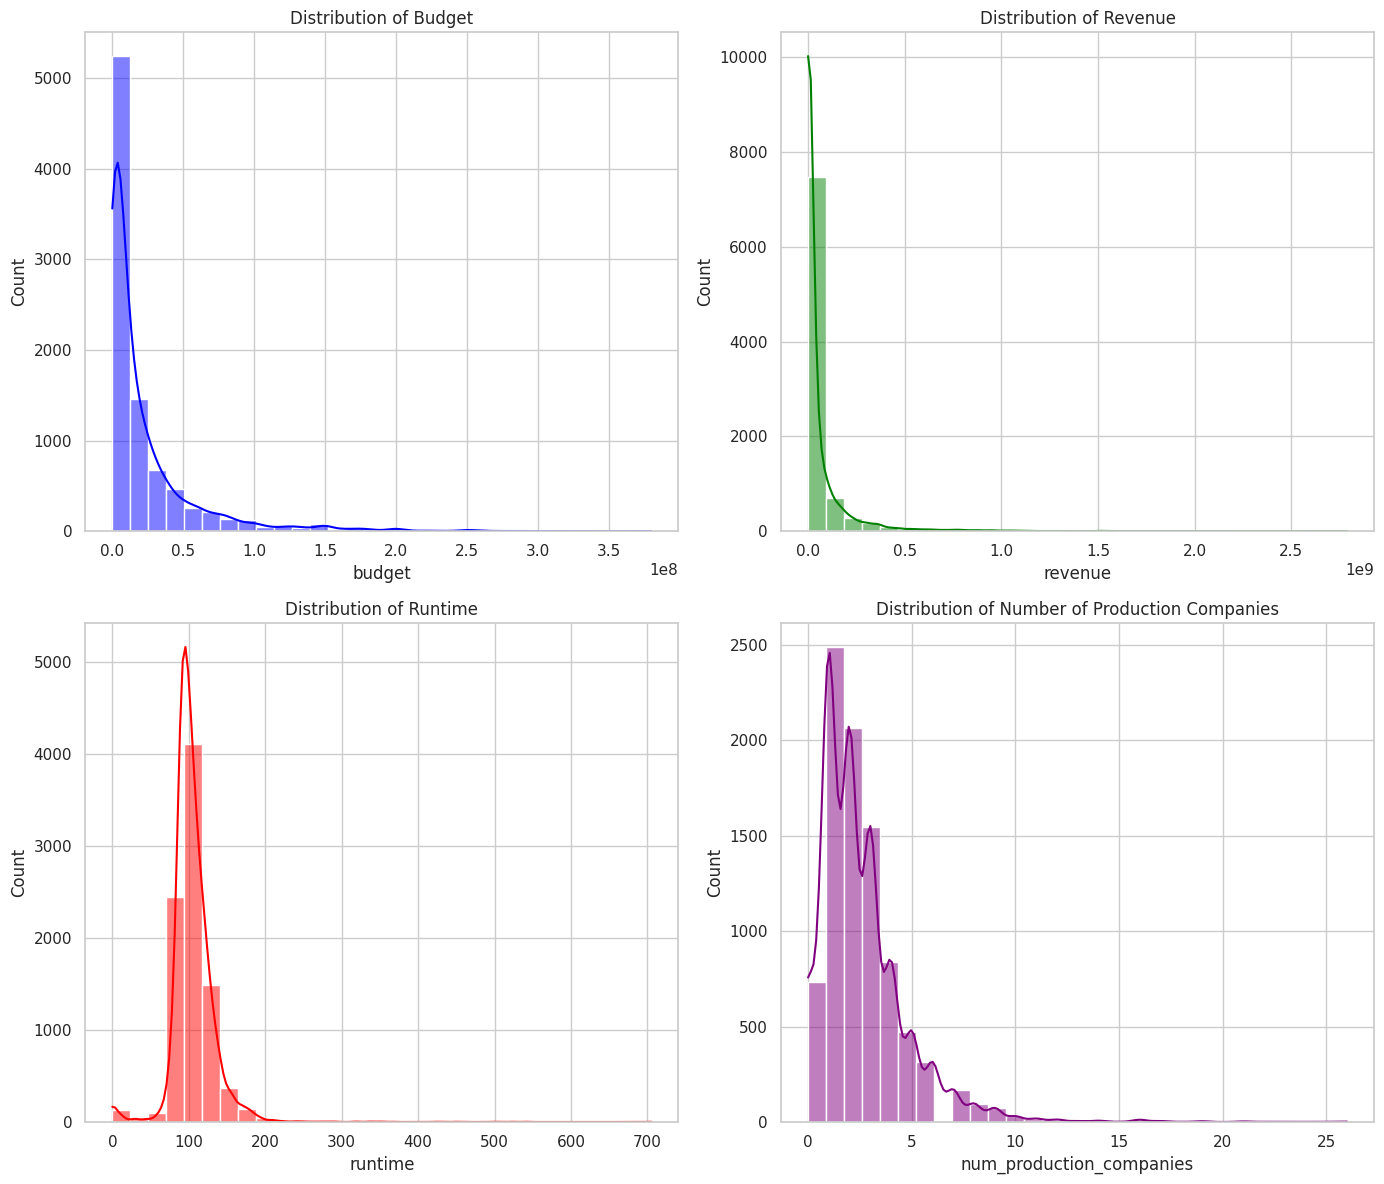

In [8]:
# Setting the style of seaborn
sns.set(style="whitegrid")

# 1. Distribution of Numerical Features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.histplot(data=movies_metadata_df, x='budget', bins=30, ax=axes[0, 0], kde=True, color='blue')
axes[0, 0].set_title('Distribution of Budget')
sns.histplot(data=movies_metadata_df, x='revenue', bins=30, ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Distribution of Revenue')
sns.histplot(data=movies_metadata_df, x='runtime', bins=30, ax=axes[1, 0], kde=True, color='red')
axes[1, 0].set_title('Distribution of Runtime')
sns.histplot(data=movies_metadata_df, x='num_production_companies', bins=30, ax=axes[1, 1], kde=True, color='purple')
axes[1, 1].set_title('Distribution of Number of Production Companies')
plt.tight_layout()
plt.show()


The histograms above provide insights into the distribution of `budget`, `revenue`, `runtime`, and `number of production companies`:

- **Budget**: Most movies have a budget less than 100 million, with a peak at lower budgets.
- **Revenue**: A similar trend is observed in revenue, with most movies earning less than 100 million.
- **Runtime**: The majority of movies have a runtime around 90 to 120 minutes.
- **Number of Production Companies**: Most movies are associated with just one production company, and very few movies have more than 5 production companies involved.

## 2.2. Categorical Feature Analysis
   - Number of movies per `primary_genre` and `primary_production_country`.

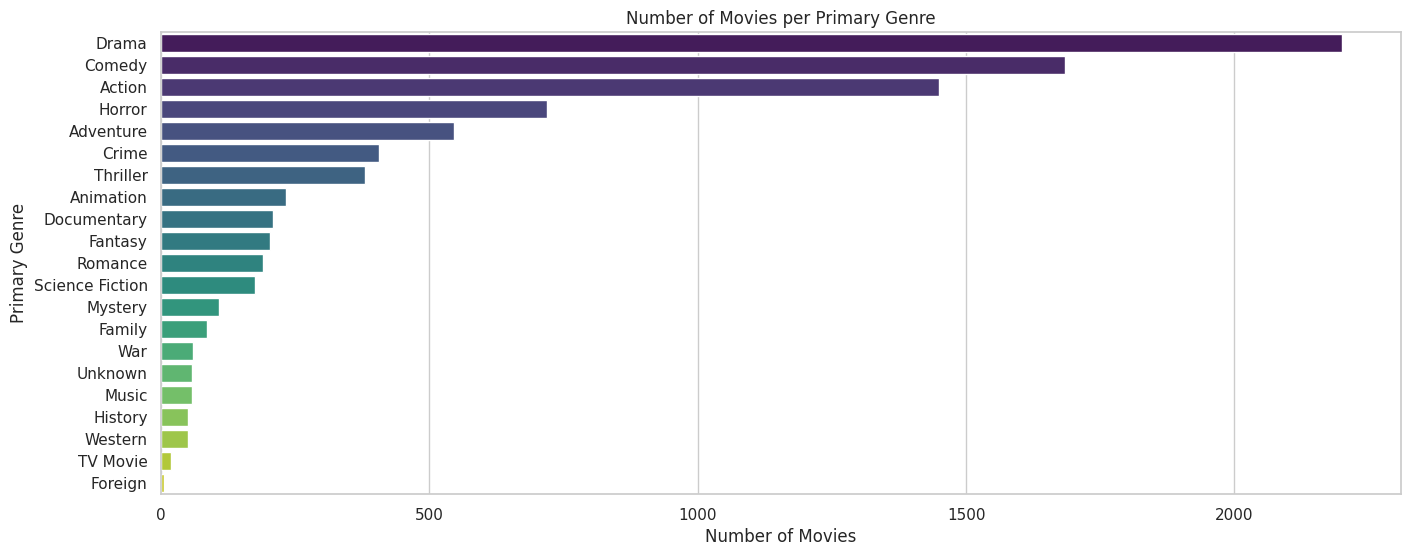

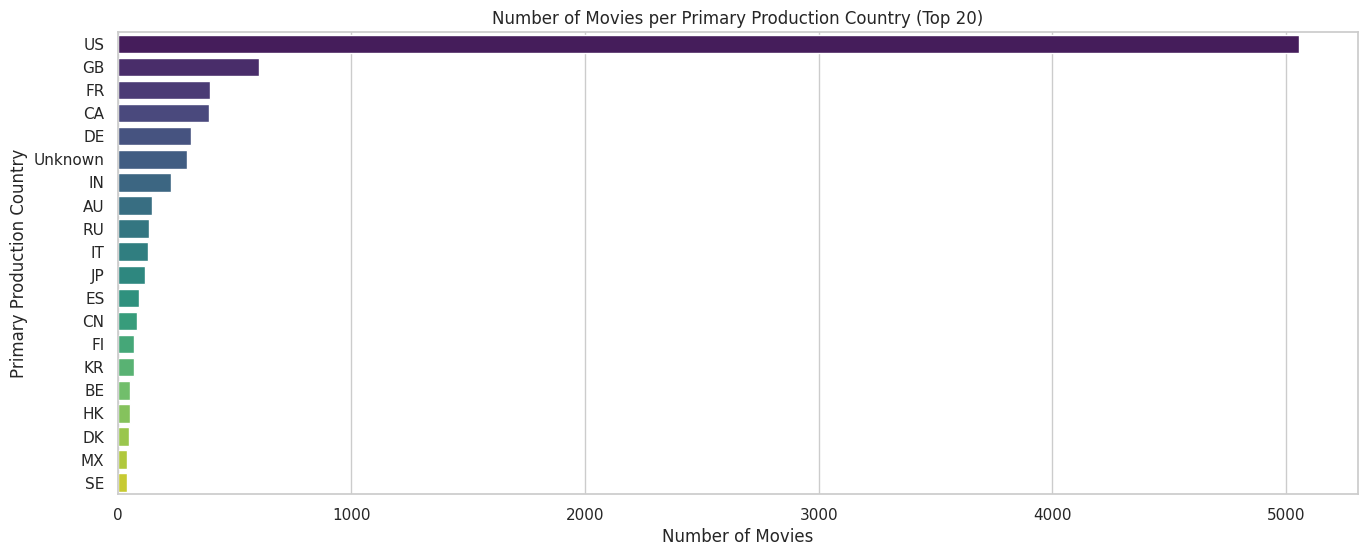

In [9]:
# 2. Categorical Feature Analysis

# Number of Movies per Primary Genre
plt.figure(figsize=(16, 6))
sns.countplot(data=movies_metadata_df, y='primary_genre', order=movies_metadata_df['primary_genre'].value_counts().index, palette="viridis")
plt.title('Number of Movies per Primary Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Primary Genre')
plt.show()

# Number of Movies per Primary Production Country (Top 20)
plt.figure(figsize=(16, 6))
sns.countplot(data=movies_metadata_df, y='primary_production_country', order=movies_metadata_df['primary_production_country'].value_counts().head(20).index, palette="viridis")
plt.title('Number of Movies per Primary Production Country (Top 20)')
plt.xlabel('Number of Movies')
plt.ylabel('Primary Production Country')
plt.show()


The visualizations above show the number of movies per `primary_genre` and `primary_production_country`:

- **Primary Genre**: Drama, Comedy, and Action are the top three genres with the highest number of movies. There's also a significant number of movies with unknown primary genres.
- **Primary Production Country**: The United States (US) is by far the leading country in terms of movie production, followed by other countries like the United Kingdom (GB), France (FR), and Germany (DE).

## 2.3. Time-based Analysis
   - Number of movies released each year (`release_year`).
   - Monthly distribution of movie releases (`release_month`).
   

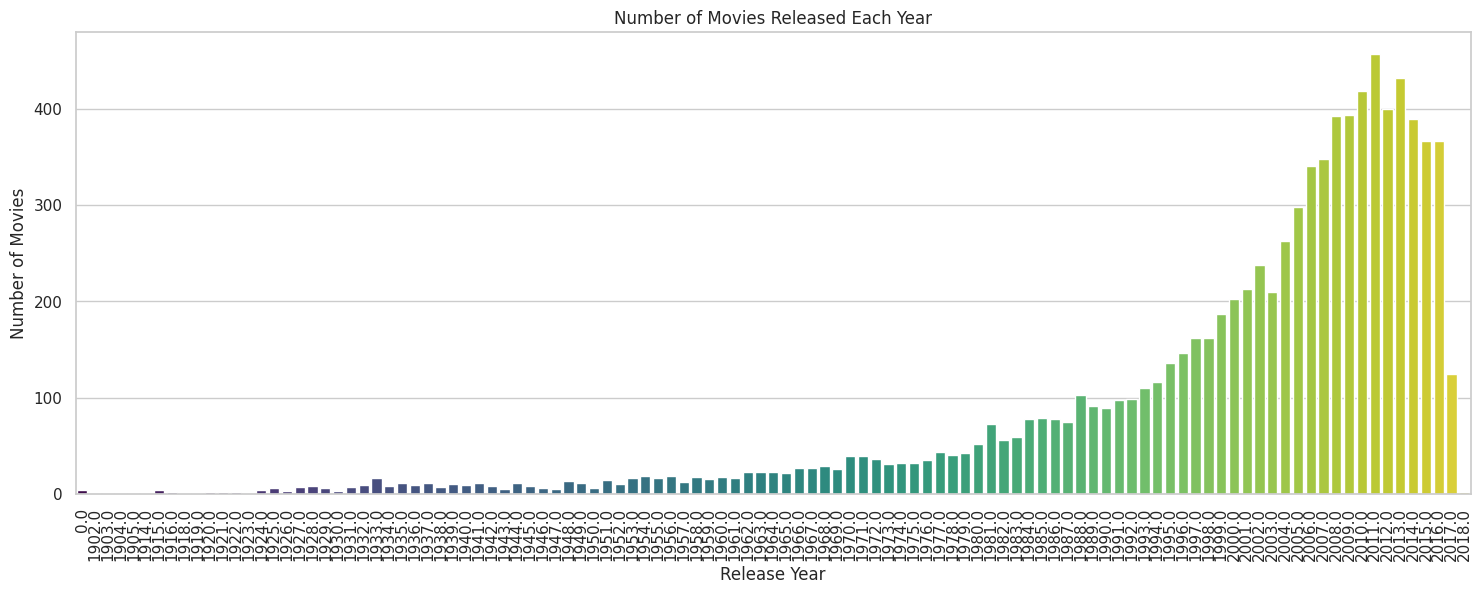

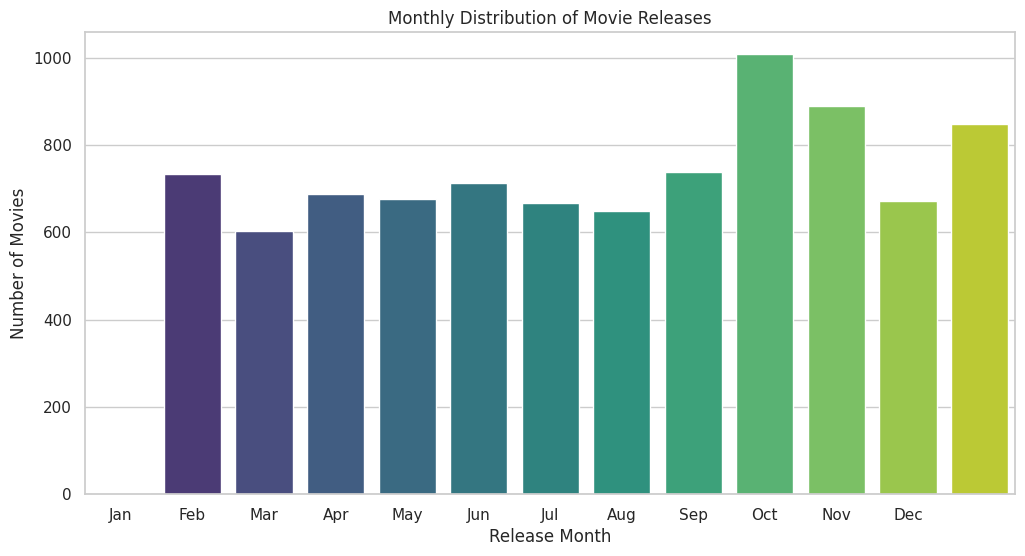

In [10]:
# 3. Time-based Analysis

# Number of Movies Released Each Year
plt.figure(figsize=(18, 6))
sns.countplot(data=movies_metadata_df, x='release_year', palette="viridis")
plt.title('Number of Movies Released Each Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

# Monthly Distribution of Movie Releases
plt.figure(figsize=(12, 6))
sns.countplot(data=movies_metadata_df, x='release_month', palette="viridis")
plt.title('Monthly Distribution of Movie Releases')
plt.xlabel('Release Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


The visualizations above provide insights into the time-based distribution of movie releases:

- **Number of Movies Released Each Year**: 
  - There's a steady increase in the number of movies released each year, with a noticeable peak around 2014-2015. 
  - There's a sharp decline in 2016 and beyond, which might be due to incomplete data for these years.

- **Monthly Distribution of Movie Releases**: 
  - The most popular months for movie releases are January and September, followed by October and December. 
  - These trends might be related to the timing of film festivals, awards season, and holiday periods.

## 2.4. Correlation Analysis
   - Correlation between numerical features.

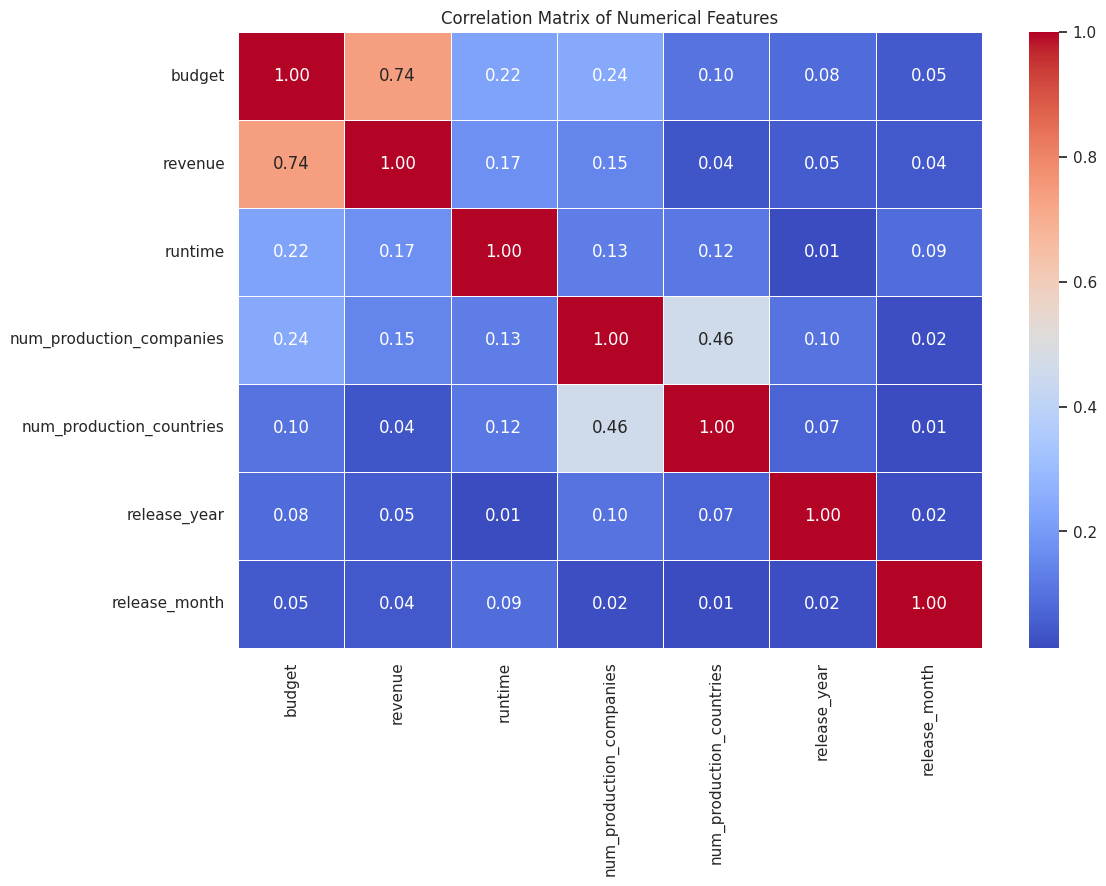

In [11]:
# 4. Correlation Analysis

# Calculating the correlation matrix
correlation_matrix = movies_metadata_df[['budget', 'revenue', 'runtime', 'num_production_companies', 'num_production_countries', 'release_year', 'release_month']].corr()

# Plotting the heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


The heatmap above displays the correlation between various numerical features:

- **Budget and Revenue**: There is a positive correlation 0.74 between budget and revenue, indicating that movies with higher budgets tend to generate higher revenues.
- **Runtime and Revenue**: The correlation between runtime and revenue is relatively low 0.17.
- **Number of Production Companies and Revenue**: This also has a low correlation 0.15 with revenue.
- **Release Year and Revenue**: There is also a low correlation 0.05 between release year and revenue.

## 2.5. Revenue Analysis
   - Revenue vs. Budget.
   - Revenue vs. Runtime.

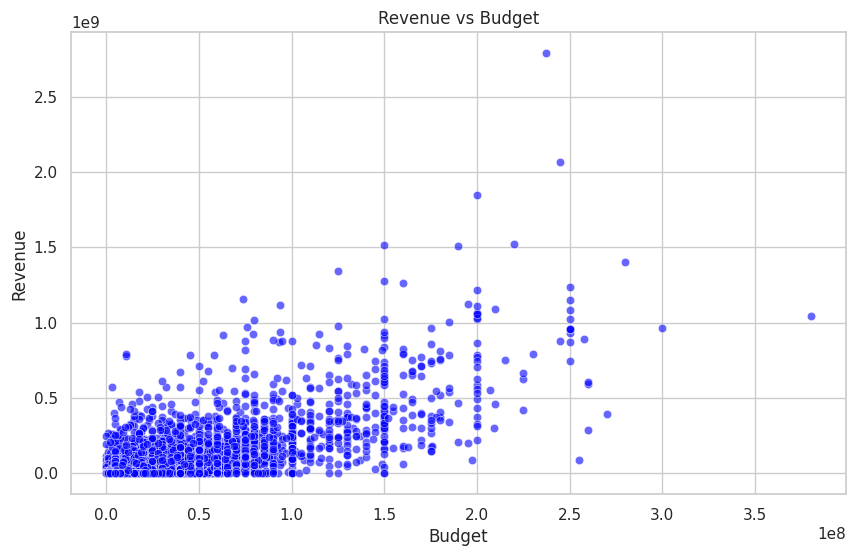

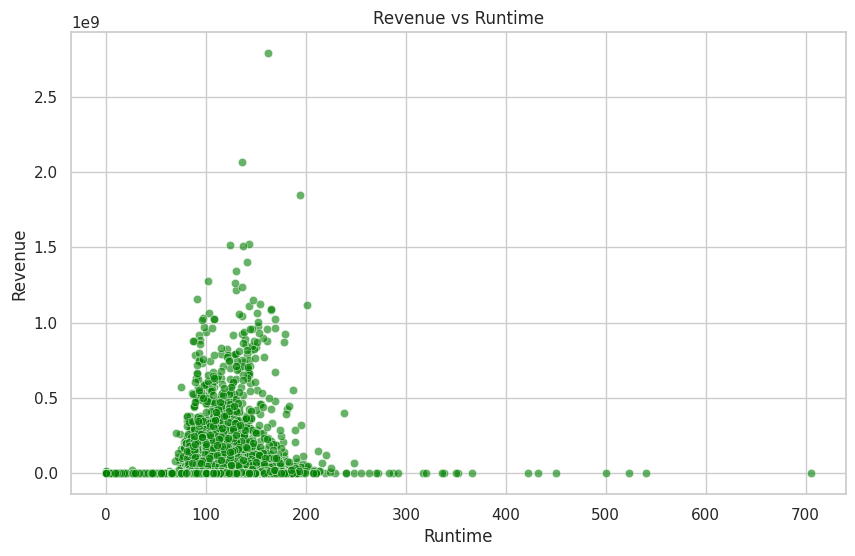

In [12]:
# 5. Revenue Analysis

# Revenue vs Budget
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_metadata_df, x='budget', y='revenue', color='blue', alpha=0.6)
plt.title('Revenue vs Budget')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

# Revenue vs Runtime
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_metadata_df, x='runtime', y='revenue', color='green', alpha=0.6)
plt.title('Revenue vs Runtime')
plt.xlabel('Runtime')
plt.ylabel('Revenue')
plt.show()


The scatter plots above display the relationship between revenue and other features:

- **Revenue vs. Budget**: 
  - There is a clear trend indicating that movies with higher budgets generally tend to generate higher revenues. 
  - There are also instances of movies with low budgets generating high revenues, indicating the presence of some successful low-budget movies.

- **Revenue vs. Runtime**: 
  - There is no distinct trend observed between revenue and runtime.

# 3. Baseline Model Building

To start making predictions is common practice to start with a baseline model, the most classic model to this type of problem is a simple linear regression model. Before using the model, it is a good idea to do some feature engineering so we can use the categorical data.

## 3.1. Feature Engineering

To use the categorical columns, there must be done one-hot encoding (another option is doing target encoding, this would probably be better for "primary_production_company' because there are many different companies, and probably a best approach to language and country would be to classify between only two... US and other, because of the quantity of data for every other country being very low).

In [13]:
# One-Hot Encoding for Categorical Variables
categorical_columns = ['primary_genre', 'secondary_genre', 'tertiary_genre', 'primary_production_company', 
                       'primary_production_country', 'original_language']

# Performing one-hot encoding
movies_metadata_encoded_df = pd.get_dummies(movies_metadata_df, columns=categorical_columns, drop_first=True)

# Previewing the dataset after one-hot encoding
movies_metadata_encoded_df.head()


,budget,revenue,runtime,num_production_companies,num_production_countries,release_year,release_month,primary_genre_Adventure,primary_genre_Animation,primary_genre_Comedy,...,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_xx,original_language_zh
original_title,,,,,,,,,,,,,,,,,,,,,
Toy Story,30000000.0,373554033.0,81.0,1.0,1.0,1995.0,10.0,False,True,False,...,False,False,False,False,False,False,False,False,False,False
Jumanji,65000000.0,262797249.0,104.0,3.0,1.0,1995.0,12.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
Waiting to Exhale,16000000.0,81452156.0,127.0,1.0,1.0,1995.0,12.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
Heat,60000000.0,187436818.0,170.0,3.0,1.0,1995.0,12.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Sabrina,58000000.0,0.0,127.0,7.0,2.0,1995.0,12.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False


## 3.2. Creating the Model

As mentioned before, the chosen model for the baseline will be the classic Linear Regression, next are the train/test split, model building, predicting using the model, and model evaluation.

In [14]:
# Defining the features (X) and the target (y)
X = movies_metadata_encoded_df.drop(columns=['revenue'])
y = movies_metadata_encoded_df['revenue']

# Splitting the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building a Linear Regression Model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predicting the target for the testing set
y_pred = linear_reg_model.predict(X_test)

# Calculating the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

mae

48772456.17517869

The baseline model has a MAE (Mean Absolute Error) of ~50 MM USD, good for the high budget movies, but not that much for the common < 100 MM USD budget movies.

# 4. Model Refinement

To improve the MAE of the model we are going to use feature engineering (in this case one-hot encoder) and we are going to exclude the outliers.

## 4.1. One-Hot Encoding

The first step is going to use the categorical columns in the model by using one-hot encoding, but after tests I discovered that using all the categorical features led to overfitting, so we are only going to use one (primary genre).

In [15]:
# Excluding specified columns
new_cleaned_data_df = movies_metadata_df.drop(columns=['original_language', 'secondary_genre', 'tertiary_genre', 'primary_production_company', 'primary_production_country'])

# Viewing the first few rows of the modified dataset
new_cleaned_data_df.head()


,budget,revenue,runtime,primary_genre,num_production_companies,num_production_countries,release_year,release_month
original_title,,,,,,,,
Toy Story,30000000.0,373554033.0,81.0,Animation,1.0,1.0,1995.0,10.0
Jumanji,65000000.0,262797249.0,104.0,Adventure,3.0,1.0,1995.0,12.0
Waiting to Exhale,16000000.0,81452156.0,127.0,Comedy,1.0,1.0,1995.0,12.0
Heat,60000000.0,187436818.0,170.0,Action,3.0,1.0,1995.0,12.0
Sabrina,58000000.0,0.0,127.0,Comedy,7.0,2.0,1995.0,12.0


Only numerical features and a single categorical feature in the data. Now is the one-hot encoding for this feature.

In [16]:
# One-Hot Encoding for 'primary_genre'
new_cleaned_data_encoded_df = pd.get_dummies(new_cleaned_data_df, columns=['primary_genre'], drop_first=True)

# Defining the features (X) and the target (y) again
X = new_cleaned_data_encoded_df.drop(columns=['revenue'])
y = new_cleaned_data_encoded_df['revenue']

# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building a Linear Regression Model again
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predicting the target for the testing set
y_pred = linear_reg_model.predict(X_test)

# Calculating the Mean Absolute Error (MAE) again
mae = mean_absolute_error(y_test, y_pred)

mae


43119430.52780302

The Mean Absolute Error (MAE) of the Linear Regression model on the testing set is approximately 43,119,430 (around 43.1 million).

This value is slightly lower than our previous attempts, which is a positive indication. It suggests that simplifying the model and focusing on the most relevant features might help improve the model's performance.

Now, let's try to drop even the genre column.

In [17]:
# Excluding 'primary_genre' related columns (after one-hot encoding)
cols_to_drop = [col for col in new_cleaned_data_encoded_df.columns if 'primary_genre' in col]
new_cleaned_data_encoded_df = new_cleaned_data_encoded_df.drop(columns=cols_to_drop)

# Defining the features (X) and the target (y) again
X = new_cleaned_data_encoded_df.drop(columns=['revenue'])
y = new_cleaned_data_encoded_df['revenue']

# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building a Linear Regression Model again
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predicting the target for the testing set
y_pred = linear_reg_model.predict(X_test)

# Calculating the Mean Absolute Error (MAE) again
mae = mean_absolute_error(y_test, y_pred)

mae


42529754.29970167

The Mean Absolute Error (MAE) of the Linear Regression model on the testing set, after excluding the `primary_genre`, is approximately 42,529,754 (around 42.5 million).

This is a further reduction in the MAE, suggesting that excluding the genre information has led to a slight improvement in the model's prediction accuracy.

This was suspected because there was many (>20) different primary genres, and most with less than 300 movies, so this feature only led to more problems (overfitting) than gains, but the genre of the movies could be used with some more feature engineering by joining many genres in a "other" category; also transforming drama, comedy and action in more categories, like action-war, drama-historical could be a good idea because of the great amount of movies in these three categories.

Let's proceed stepwise to refine the model. Here's a suggested order to start with:

## 4.2. Handling Outliers

    We can begin by examining and handling outliers in the numeric features (`budget`, `runtime`, and `revenue`). Outliers can significantly impact the performance of a linear regression model.

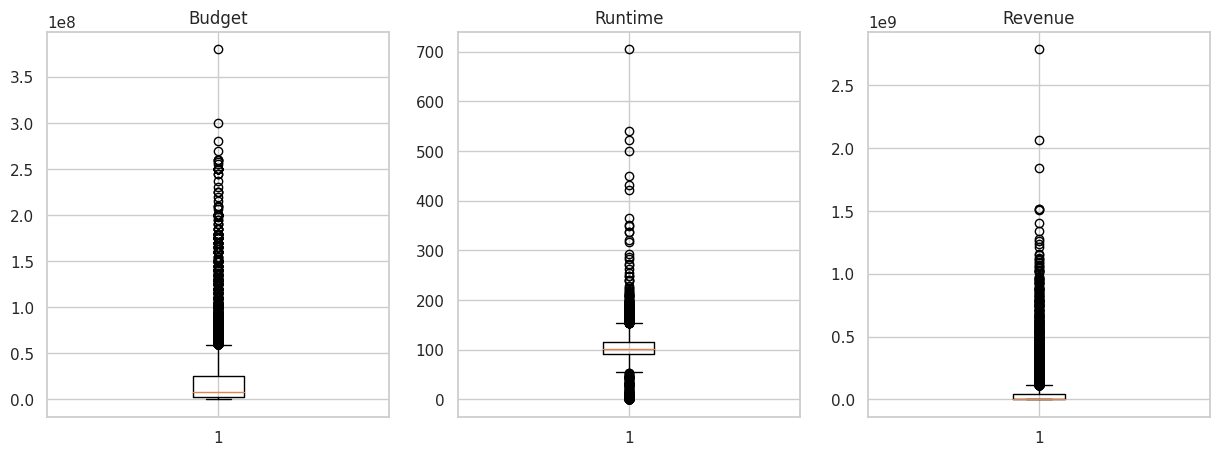

In [18]:
# Plotting boxplots to visualize the distribution and identify outliers for 'budget', 'runtime', and 'revenue'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Boxplot for 'budget'
axes[0].boxplot(new_cleaned_data_encoded_df['budget'])
axes[0].set_title('Budget')

# Boxplot for 'runtime'
axes[1].boxplot(new_cleaned_data_encoded_df['runtime'].dropna())  # Dropping NaN values for plotting
axes[1].set_title('Runtime')

# Boxplot for 'revenue'
axes[2].boxplot(new_cleaned_data_encoded_df['revenue'])
axes[2].set_title('Revenue')

plt.show()


From the boxplots, we can observe that there are outliers in the `budget`, `runtime`, and `revenue` columns. These outliers can have a significant impact on the performance of the model.

For handling outliers, we can use the Interquartile Range (IQR) method, where we can define bounds, and values outside these bounds can be considered as outliers.

In [19]:
# Defining a function to remove outliers using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Removing outliers from 'budget', 'runtime', and 'revenue'
new_cleaned_data_encoded_df = remove_outliers_iqr(new_cleaned_data_encoded_df, 'budget')
new_cleaned_data_encoded_df = remove_outliers_iqr(new_cleaned_data_encoded_df, 'runtime')
new_cleaned_data_encoded_df = remove_outliers_iqr(new_cleaned_data_encoded_df, 'revenue')

# Checking the shape of the DataFrame after removing outliers
new_cleaned_data_encoded_df.shape


(6470, 7)

After removing the outliers, the dataset now contains 6,470 entries, down from the original size. This reduction helps in eliminating extreme values that can adversely affect the model's performance.

Now we proceed to retrain the Linear Regression model with this cleaned data to check if there is an improvement in the Mean Absolute Error (MAE).

In [20]:
# Defining the features (X) and the target (y) again after removing outliers
X = new_cleaned_data_encoded_df.drop(columns=['revenue'])
y = new_cleaned_data_encoded_df['revenue']

# Splitting the dataset into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Building a Linear Regression Model again
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

# Predicting the target for the testing set
y_pred = linear_reg_model.predict(X_test)

# Calculating the Mean Absolute Error (MAE) again
mae = mean_absolute_error(y_test, y_pred)

mae


9173138.060163304

The Mean Absolute Error (MAE) of the Linear Regression model on the testing set, after handling outliers, is approximately 9,173,138 (around 9.2 million). 

This is a substantial improvement compared to the previous MAE of around 42.5 million. It demonstrates the significant impact of handling outliers on improving the model's performance.

I also tried more advanced techniques like using advanced algorithms (random forest and gradient boosting) and polynomial features but the gains were minimal.

## 4.3. Adding More Datasets (discussion)

A possible next step would be to add more data for the model to work with, these are five datasets that could bring value, I did not used they because there were much smaller than the The Movies Datasets (all are available in Kaggle).

In [21]:
data_movies = pd.read_csv('/kaggle/input/movies/movies.csv')
print(data_movies.head())
data_movies.info()
data_movies.describe()

                                             name rating      genre  year  \
0                                     The Shining      R      Drama  1980   
1                                 The Blue Lagoon      R  Adventure  1980   
2  Star Wars: Episode V - The Empire Strikes Back     PG     Action  1980   
3                                       Airplane!     PG     Comedy  1980   
4                                      Caddyshack      R     Comedy  1980   

                        released  score      votes         director  \
0  June 13, 1980 (United States)    8.4   927000.0  Stanley Kubrick   
1   July 2, 1980 (United States)    5.8    65000.0   Randal Kleiser   
2  June 20, 1980 (United States)    8.7  1200000.0   Irvin Kershner   
3   July 2, 1980 (United States)    7.7   221000.0     Jim Abrahams   
4  July 25, 1980 (United States)    7.3   108000.0     Harold Ramis   

                    writer            star         country      budget  \
0             Stephen King  Jack Nic

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


Features that could be added: rating, director, star and writer.

In [22]:
data_celebrities = pd.read_csv('/kaggle/input/forbes-celebrity-100-since-2005/forbes_celebrity_100.csv')
print(data_celebrities.head())
data_celebrities.info()
data_celebrities.describe()

               Name  Pay (USD millions)  Year             Category
0     Oprah Winfrey               225.0  2005        Personalities
1       Tiger Woods                87.0  2005             Athletes
2        Mel Gibson               185.0  2005               Actors
3      George Lucas               290.0  2005  Directors/Producers
4  Shaquille O'Neal                33.4  2005             Athletes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                1647 non-null   object 
 1   Pay (USD millions)  1647 non-null   float64
 2   Year                1647 non-null   int64  
 3   Category            1647 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 51.6+ KB


,Pay (USD millions),Year
count,1647.000000,1647.000000
mean,47.063995,2012.633880
std,40.439071,4.616274
min,1.500000,2005.000000
25%,27.250000,2009.000000
50%,40.000000,2013.000000
75%,56.000000,2017.000000
max,620.000000,2020.000000


Could be added using the star feature in the previously dataset, if the star is in that list, than is a major hollywood star.

In [23]:
data_tmdb_5000 = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')
print(data_tmdb_5000.head())
data_tmdb_5000.info()
data_tmdb_5000.describe()

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Keywords feature could be a easier to use alternative to long descriptions, using these more complex features could lead to very interesting EDA and even better prediction models.

In [24]:
data_wiki = pd.read_csv('/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')
print(data_wiki.head())
data_wiki.info()
data_wiki.describe()

   Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


Following the last comment, Plot feature could lead to a more complex and interesting analysis.

In [25]:
data_highest_grossing = pd.read_csv('/kaggle/input/top-1000-highest-grossing-movies/Highest Holywood Grossing Movies.csv')
print(data_highest_grossing.head())
data_highest_grossing.info()
data_highest_grossing.describe()

   Unnamed: 0                                       Title  \
0           0                                      Avatar   
1           1                           Avengers: Endgame   
2           2                    Avatar: The Way of Water   
3           3                                     Titanic   
4           4  Star Wars: Episode VII - The Force Awakens   

                                          Movie Info  Year  \
0  A paraplegic Marine dispatched to the moon Pan...  2009   
1  After the devastating events of Avengers: Infi...  2019   
2  Jake Sully lives with his newfound family form...  2022   
3  A seventeen-year-old aristocrat falls in love ...  1997   
4  As a new threat to the galaxy rises, Rey, a de...  2015   

                           Distributor                 Budget (in $)  \
0                Twentieth Century Fox                     237000000   
1  Walt Disney Studios Motion Pictures                     356000000   
2                 20th Century Studios  Dece

,Unnamed: 0,Year,Domestic Sales (in $),International Sales (in $),World Wide Sales (in $)
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03
mean,499.500000,2008.181000,1.646405e+08,2.640890e+08,4.228430e+08
std,288.819436,10.585854,1.197541e+08,2.133847e+08,3.054844e+08
min,0.000000,1937.000000,6.752000e+03,2.450000e+07,1.799689e+08
25%,249.750000,2002.000000,9.572506e+07,1.321190e+08,2.272899e+08
50%,499.500000,2010.000000,1.349169e+08,1.941077e+08,3.197148e+08
75%,749.250000,2016.000000,1.983993e+08,3.188993e+08,4.852363e+08
max,999.000000,2023.000000,9.366622e+08,2.138484e+09,2.923706e+09


An interesting feature engineering idea is to use revenue divided by budget as a success factor, usually 2 is very good for hollywood standards, using this dataset we could also create a very successful feature (or metric), this was done in a previously project of mine: https://www.kaggle.com/code/victorpaschoalini/movie-revenue-prediction-success-classification/notebook

# Conclusion

Budget is the most important feature when trying to estimate the revenue, most budgets are below 100 MM USD.

Using a simple regression model dropping the budget outliers we got a MAE of ~9.2 MM USD for the revenues.